# Scalable learning with polynomial kernel approximation
- `PolynomialCountSketch`를 사용하여 다항식 커널 피처 공간 근사치를 효율적으로 생성하는 방법을 보여줌

## Preparing the data

In [2]:
from sklearn.datasets import fetch_covtype

X, y = fetch_covtype(return_X_y=True)

y[y != 2] = 0
y[y == 2] = 1  # 2개의 클래스를 6개의 클래스로 나눔

## Partitioning the data

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=5_000, test_size=10_000, random_state=42
)

## Feature normalization

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer

mm = make_pipeline(MinMaxScaler(), Normalizer())
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

## Establishing a baseline model

In [5]:
import time

from sklearn.svm import LinearSVC

results = {}

lsvm = LinearSVC(dual="auto")
start = time.time()
lsvm.fit(X_train, y_train)
lsvm_time = time.time() - start
lsvm_score = 100 * lsvm.score(X_test, y_test)

results["LSVM"] = {"time": lsvm_time, "score": lsvm_score}
print(f"Linear SVM score on raw features: {lsvm_score:.2f}%")

Linear SVM score on raw features: 75.62%


## Establishing the kernel approximation model

In [6]:
from sklearn.kernel_approximation import PolynomialCountSketch

n_runs = 1
N_COMPONENTS = [250, 500, 1000, 2000]

for n_components in N_COMPONENTS:
    ps_lsvm_time = 0
    ps_lsvm_score = 0
    for _ in range(n_runs):
        pipeline = make_pipeline(
            PolynomialCountSketch(n_components=n_components, degree=4),
            LinearSVC(dual="auto"),
        )

        start = time.time()
        pipeline.fit(X_train, y_train)
        ps_lsvm_time += time.time() - start
        ps_lsvm_score += 100 * pipeline.score(X_test, y_test)

    ps_lsvm_time /= n_runs
    ps_lsvm_score /= n_runs

    results[f"LSVM + PS({n_components})"] = {
        "time": ps_lsvm_time,
        "score": ps_lsvm_score,
    }
    print(
        f"Linear SVM score on {n_components} PolynomialCountSketch "
        + f"features: {ps_lsvm_score:.2f}%"
    )

Linear SVM score on 250 PolynomialCountSketch features: 76.34%
Linear SVM score on 500 PolynomialCountSketch features: 77.19%
Linear SVM score on 1000 PolynomialCountSketch features: 78.21%
Linear SVM score on 2000 PolynomialCountSketch features: 78.24%


## Establishing the kernelized SVM model

In [7]:
from sklearn.svm import SVC

ksvm = SVC(C=500.0, kernel="poly", degree=4, coef0=0, gamma=1.0)

start = time.time()
ksvm.fit(X_train, y_train)
ksvm_time = time.time() - start
ksvm_score = 100 * ksvm.score(X_test, y_test)

results["KSVM"] = {"time": ksvm_time, "score": ksvm_score}
print(f"Kernel-SVM score on raw features: {ksvm_score:.2f}%")

Kernel-SVM score on raw features: 79.78%


## Comparing the results

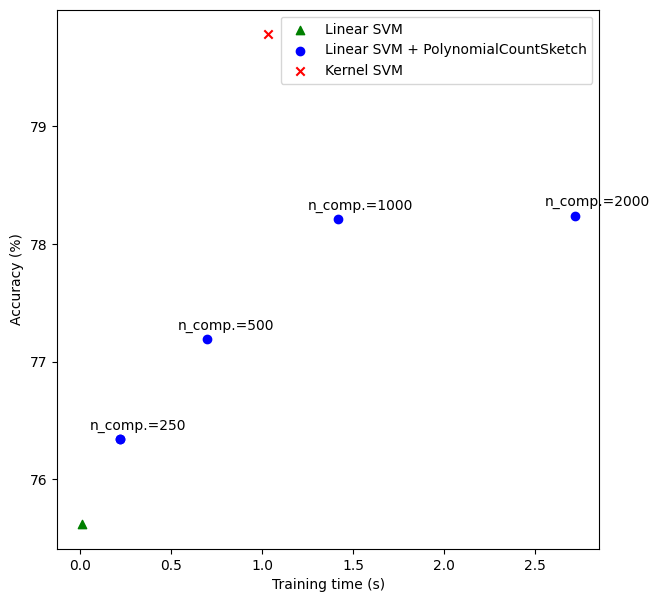

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    [
        results["LSVM"]["time"],
    ],
    [
        results["LSVM"]["score"],
    ],
    label="Linear SVM",
    c="green",
    marker="^",
)

ax.scatter(
    [
        results["LSVM + PS(250)"]["time"],
    ],
    [
        results["LSVM + PS(250)"]["score"],
    ],
    label="Linear SVM + PolynomialCountSketch",
    c="blue",
)

for n_components in N_COMPONENTS:
    ax.scatter(
        [
            results[f"LSVM + PS({n_components})"]["time"],
        ],
        [
            results[f"LSVM + PS({n_components})"]["score"],
        ],
        c="blue",
    )
    ax.annotate(
        f"n_comp.={n_components}",
        (
            results[f"LSVM + PS({n_components})"]["time"],
            results[f"LSVM + PS({n_components})"]["score"],
        ),
        xytext=(-30, 10),
        textcoords="offset pixels",
    )

ax.scatter(
    [
        results["KSVM"]["time"],
    ],
    [
        results["KSVM"]["score"],
    ],
    label="Kernel SVM",
    c="red",
    marker="x",
)

ax.set_xlabel("Training time (s)")
ax.set_ylabel("Accuracy (%)")
ax.legend()
plt.show()